In [1]:
%run drop_test_analysis.ipynb

# Mission Analysis of Drop Test for Electromechanical Recovery System

## Background
PSAS is planning to test a recovery system by releasing it from a helicopter over a field.

## Purpose
The purpose of this document is to ascertain the dispersal pattern of impacts under a range of contingencies, so as to delimit the acceptable environmental conditions under which the safety of people, property, and the test article can be assured. For safety and liability reasons, we must have an expectation of the area the recovery system may land in. 

## Problem Statement
What is the Circular Error Probable (CEP) for the upcoming drop test of the Electromechanical Recovery System (ERS) under a range of possible scenarios?

## Definition
CEP gives the mean distance of a sample of points from their mean impact point. That is, a circle around the average point that contains 50% of the sample points. CEP is defined as the square root of the mean squared error, which is the averaged sum over range and azimuth variances, covariance, and estimated GPS variance.

## Scenarios
The primary variable we are considering is wind condition, as velocity and heading measured from the ground. The airspeed and initial position are also varied to account for piloting tolerance. Because the target field is longer in one direction, two separate types of simulations are conducted: flying against the wind and flying perpendicular to the wind.

There are four operational modes (that is, three failure modes and a successful mission) to consider:
* We consider the case that the mission is successful.
* The two cases where the ERS system completely fails and only the drogue parachute fails are indistinguishable, given the altitude we drop from.
* We will consider the case where the drogue deploys correctly but remains attached, while the main chute does not deploy.
* We consider the case where the main chute deploys when the drogue is supposed to, which we expect to provide our worst case in terms of CEP spread.

The wind speed is set by a Rayleigh distribution with a scale parameter of 4.8 knots (on the ground). We model the wind direction as a normal distribution about a fixed direction, with a standard deviation of 10 degrees. Thus, all simulations are contained within a 60 degree cone, and a large majority are within a 40 degree cone. 

Though simulations are conducted relative to an arbitrary direction, the results hold for any cardinal direction by rotational symmetry. The utility of this approach is that given the current wind conditions on the day of the test, we will have a prediction of where the system is likely to drift. This allows us to select our release point to bound the expected impact, and to determine on the day of operations whether there is need to cancel due to wind speeds or directions outside of the acceptable envelope.

The helicopter's target airspeed is normally distributed around 30 knots with standard deviation of 3.33 knots. Combined with the wind speed adjusted for altitude, we obtain the initial velocity of the test article with respect to the ground. The system is released from 2,000 feet and initial position error is normally distributed around 0 with 30 foot standard deviation in each horizontal axis and 15 foot standard deviation vertically.


## Methodology
The test article's trajectory is determined by a numerically integrated system of ordinary differential equations, based on first principles of physics. Details are to be found in the appendix.

A Monte Carlo simulation of trajectories is used to generate data for statistical analysis. For each type and mode of scenario, we randomly generate 2,500 trajectories according to the aforementioned random variables, and we collect every final impact point, along with their initial conditions.

Data from each mode is aggregated so that there are just two datasets to analyze, against the wind and across the wind. CEP is calculated and displayed by three squares of side length 2x CEP, 4x CEP, and 6x CEP, to bound the closest 50%, 93.7%, and 99.8% of impact points, respectively. These impact points are plotted on a Google Maps display of the target field in question.

From this notebook, we can select subsets of the data according to wind speed, and CEP is recalculated accordingly. We can also reflect, translate, or rotate the data set as if it is a rigid body (i.e. preserving relative distances of all points) to determine safe release points for each initial wind condition.

## Conclusions


In [6]:
# logic added so that we can use just this block to control each of our scenarios in tandem
max_wind = (0.0, 10)
do_cut_off = True
shift = np.array([100, -50]) # +X = East, +Y = North
do_translate = False
spin = 180 # clockwise rotation
do_rotate = False
do_reflect = False

if do_cut_off:
    aggregate_against = wind_envelope(aggregate_against, max_wind)
if do_rotate:
    aggregate_against, against_mean_wind, angle_agg_against, rls_agg_against = rotate_cluster(
                    aggregate_against, spin, against_mean_wind, angle_agg_against, rls_agg_against)
if do_translate:
    aggregate_against, rls_agg_against = translate_cluster(aggregate_against, shift, rls_agg_against)
if do_reflect:
    aggregate_against, against_mean_wind, angle_agg_against, rls_agg_against = reflect_cluster(
        aggregate_against, against_mean_wind, angle_agg_against, rls_agg_against)

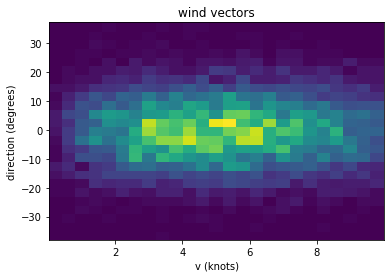

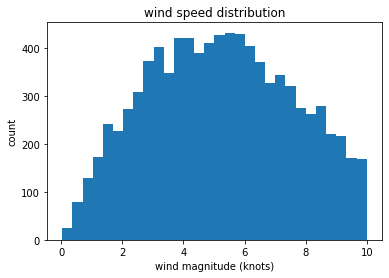

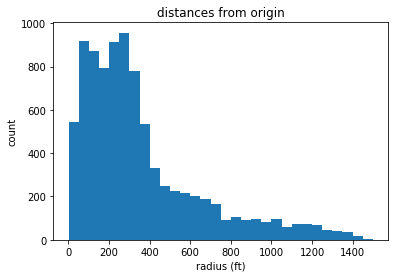

Mean wind from 270 degrees true
Release point: Lat 45.423408, Long -122.978873
Release angle: Fly heading 270 degrees true
Mean impact point: Lat 45.4234048490987, Long -122.97814317718648
Circular Error Probable: 296.7672942939593 ft


Loading BokehJS ...

In [7]:
pos_agg_against, CEP_agg_against = visualize(aggregate_against, rls_agg_against, angle_agg_against)
plot_on_map(aggregate_against, rls_agg_against, against_mean_wind, angle_agg_against, CEP_agg_against)

In [8]:
if do_cut_off:
    aggregate_across = wind_envelope(aggregate_across, max_wind)
if do_rotate:
    aggregate_across, across_mean_wind, angle_agg_across, rls_agg_across = rotate_cluster(
                    aggregate_across, spin, across_mean_wind, angle_agg_across, rls_agg_across)
if do_translate:
    aggregate_across, rls_agg_across = translate_cluster(aggregate_across, shift, rls_agg_across)
if do_reflect:
    aggregate_across, across_mean_wind, angle_agg_across, rls_agg_across = reflect_cluster(
        aggregate_across, across_mean_wind, angle_agg_across, rls_agg_across)

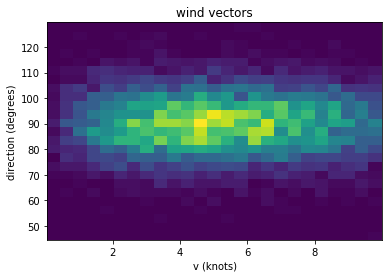

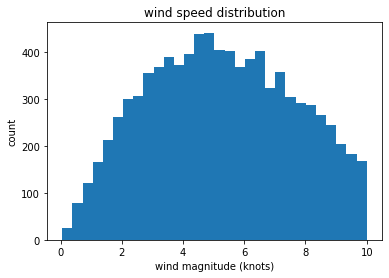

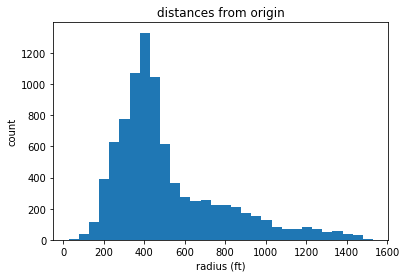

Mean wind from 180 degrees true
Release point: Lat 45.423408, Long -122.978873
Release angle: Fly heading 270 degrees true
Mean impact point: Lat 45.42451569207166, Long -122.97968845374248
Circular Error Probable: 267.17495288076094 ft


Loading BokehJS ...

In [9]:
pos_agg_across, CEP_agg_across = visualize(aggregate_across, rls_agg_across, angle_agg_across)
plot_on_map(aggregate_across, rls_agg_across, across_mean_wind, angle_agg_across, CEP_agg_across)

## Appendix

The state space of our trajectory model is $\mathbb{R}^6$, representing position and velocity of a point-mass, both in three dimensions. Note that these are ground referenced coordinates.

The equations of motion are an ordinary differential equation, given by Newton's Second Law and the drag equation, with gravity and air density assumed constant (at 9.80665 m/s and 1.2 kg/m^3, respectively). That is, $$\ddot x(t) = \frac{D(\dot x(t))}{m} - g,$$ where $$D(\dot x) = -A/2 \cdot C_d \cdot  \rho \cdot ||\dot x|| \cdot \dot x,$$ for $g$ the gravity, $A$ the frontal area, $C_d$ the drag coefficient, and $\rho$ the air density. This can be written as a system of first order equations in the usual way.

After receiving initial values of $x$ and $\dot x$, as documented earlier, our equations of motion are numerically integrated by the fourth order Runge-Kutta algorithm. This is a standard tool with truncation error on the order of $h^5$, for time step $h$. Given our time step of 0.05 seconds per step, this corresponds to an error with constant proportionality to 3.125e-7.

To simulate the stages of the recovery system's deployment, we change the values of the frontal area $A$ and the drag coefficient $C_d$ when the appropriate conditions are met, according to the values provided by the manufacturer of the drogue parachute and main parachute.

The stages of a trajectory simulation are as follows:
1. Release test article with initial position and velocity.
2. Article in free fall when slack line goes taut, which starts drogue deployment timer.
    * Per kinematic equations, slack line is taut at time t where $\frac{1}{2}gt^2 = l$, assuming $l$, length of slack line, is short enough to disregard horizontal displacement and $l = 2$ m.
3. Article in free fall as timer ticks until drogue deploys.



static_line(sim, next_step)

drogue_deploy(sim, next_step)
    
if not sim.fail_mode['early']: # skip drogue and go straight to main chute if failure mode is early deployment

    drogue_line(sim, next_step)

    drogue_action(sim, next_step)

main_chute(sim, next_step)